In [3]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
import rdkit.Chem.QED as QED
from rdkit import rdBase

rdBase.DisableLog("rdApp.error")
from rdkit.Chem import rdMolDescriptors
from rdkit.six import iteritems

import sys
import logging
import pandas as pd

In [2]:
# checking all columns are the same:
def colsdf(file_path):
    df = pd.read_csv(f'Downloads/{file_path}')
    return df.columns
for i in file_names:
    print(colsdf(i))

NameError: name 'file_names' is not defined

In [ ]:
df.columns

In [4]:
def setup_logger():
    logger = logging.getLogger("eval_contam")
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(module)s - %(message)s")
    sh = logging.StreamHandler(sys.stdout)
    sh.setFormatter(formatter)

    logger.addHandler(sh)
    return logger

logger = setup_logger()


def similarity(smiles_a, smiles_b):
    """Evaluate Tanimoto similarity between 2 SMILES strings

    Args:
      smiles_a: str, SMILES string
      smiles_b: str, SMILES string

    Returns:
      similarity score: float, between 0 and 1.

    """
    if smiles_a is None or smiles_b is None:
        return 0.0
    amol = Chem.MolFromSmiles(smiles_a)
    bmol = Chem.MolFromSmiles(smiles_b)
    if amol is None or bmol is None:
        return 0.0
    fp1 = AllChem.GetMorganFingerprintAsBitVect(amol, 2, nBits=2048, useChirality=False)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(bmol, 2, nBits=2048, useChirality=False)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def score_against_known_drugs(smiles_query, smiles_list):
    """Evaluate if a given SMILES string is close to a known list of SMILES strings
    Args:
      smiles_query: str, SMILES string
      smiles_list: list of str, SMILES strings
      
      Returns:
      similarity score: float, between 0 and 1.
      
    """
    similarity_list = []
    for smi in smiles_list:
        similarity_list.append(similarity(smi, smiles_query))
    return max(similarity_list)

In [5]:
def similarity_total(filepath, col1, col2):
    """
    takes a csv filepath string
    turns it to df. 
    gets the headers of 2 columns to compare.
    compares the strings in the two columns.
    returns different statistics.
    """
    df = pd.read_csv(filepath)
    # df['similarity_column'] = df.apply(similarity, axis=1)
    similarity_vals = []
    cols = df.columns
    # print(df)
    for index, row in df.iterrows():
        # print("Here")
        SMILE1 = row[col1]
        # print(SMILE1, type(SMILE1))
        SMILE2 = row[col2]
        # print(SMILE2, type(SMILE2))
        if not isinstance(SMILE1, str) or not isinstance(SMILE2, str):
            similarity_vals.append(None)
        else:
            similarity_vals.append(similarity(SMILE1, SMILE2))

    df['similarity_column'] = similarity_vals
    #getting stats
    average_value = df['similarity_column'].mean()
    max_value = df['similarity_column'].max()
    min_value = df['similarity_column'].min()

    stats = {"Mean" : average_value, "Max": max_value, "Min": min_value}

    return stats

In [6]:
df = pd.read_csv("out_50_train_experiment.csv")
# type(df["top_0"][10]) == 
df

,Real Response,Model Response,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9
0,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO.C1C...,CC(=O)N1CCC=2C1=C(C3CC4=C(C(=C3N2)C(=O)COC5=CC...,CCc1ccc(CF)c2nc3c(c(CO)c12)N(C(C)=O)CC3,CCc1ccc(CF)c2nc3c(c(CN)c12)N(C(C)=O)CC3,CCCc1ccc(C)c2c(CO)c3c(nc12)CCN3C(C)=O,CCCc1ccc(C)c2c(CN)c3c(nc12)CCN3C(C)=O,CC(=O)N1CCc2nc3c(CCF)ccc(C)c3c(CO)c21,CCc1nc(O)c2c(CC)c3c(nc2c1CC)CCN3C(C)=O,CC(=O)N1CCc2nc3c(COF)ccc(C)c3c(CO)c21,CCc1nc(O)c2c(CF)c3c(nc2c1CC)CCN3C(C)=O,CCc1nc(CO)c2c(C)c3c(nc2c1CC)CCN3C(C)=O,Cc1ccc(COCF)c2nc3c(c(F)c12)N(O)CN=C3
1,C1CC(=O)NC2=C1C=CC(=C2)OCCCCN3CCN(CC3)C4=C(C(=...,CC(=O)N[C@@H](CCC1=CC(=C(C=C1)O)F)C1=CC2=C(C=C...,CC(=O)NC1C=C(Cc2ccc3nc(C)nc(C)c3c2)C=C1C,Nc1nc(CF)nc2c1CC(Cc1ccc(F)cc1F)=C2,Cc1nc(N)c2c(F)c3c(cc2n1)CC([C@@H](F)CCF)CC3,Cc1nc(N)c2c(n1)C=C(Cc1ccc(F)cc1CF)C2,CC(=O)Cc1nc(O)c2c(n1)C(Cc1ccc(F)c(C)c1)=CC2,Cc1nc(CF)nc2c1C=C(Cc1ccc(O)c(F)c1)C2,CC(=O)Cc1nc(O)c2c(n1)C(Cc1ccc(C)c(C)c1)=CC2,CC(=O)C1=C(Cc2ccc(F)c(C)c2)Cc2c(N)nc(C)nc2C1,CC1=C([C@@H](F)CCF)Cc2cc3nc(C)nc(N)c3c(F)c21,CC(=O)Cc1ccc(CC2=Cc3nc(C)nc(N)c3C2)cc1
2,CC1(CCC(=C(C1)C2=CC=C(C=C2)Cl)CN3CCN(CC3)C4=CC...,CC1(C2C(C3(C(C(=O)C(=C(N3C2(C(=O(C1=O)C)C)C(=O...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC(=O)NCCCS(=O)(=O)[O-].CC(=O)NCCCS(=O)(=O)[O-...,C1=CC(=C(C(=C1)Cl)N)N.C(C(C(=O)O)N)S.Cl.C(C1=C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[H+].[H+].[H+].[H+].[H+].[H+].[H+].[H+].[H+].C...,C1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])N(=O)[O...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,C1=CC=C(C=C1)CC(COC(=O)N)N.Cl,C1CC2CC3CC1CC(C2)(C3)C(=O)NC.OS(=O)(=O)O.Cl,O=S(=O)(Nc1ccccc1)C12CC3CCC(CC(C3)C1)C2,CCC1=CC2(S(=O)(=O)c3c(C)[nH]c4c3C(=O)CC4C)C=C(...,O=C1C2CC3CC(C2)CC1(NS(=O)(=O)C1=CCCCC1)C3,CC(=O)NC(C)S(=O)(=O)C12CC(C)CC(CC(C)C1)C2,CCCC1CC2=CC(C)=CC(S(=O)(=O)C(=O)NC)(C2)C1,CCC(C)S(=O)(=O)NC(=O)C12CCCC(CC(C)C1)C2,CCC1=CC=C2CCCC2(CC(=O)S(=O)(=O)C(=O)NC)C1,CCC1CC2CCCC(S(=O)(=O)C(C)NC(C)=O)(C1)C2,CCC1CC2CCCC(CC(=O)S(=O)(=O)C(=O)NC)(C1)C2,CCCC1CC2CCCC(S(=O)(=O)C(=O)NC)(C1)C2
96,C1=CC(=NC=C1CC2=CNC3=C2C=C(C=N3)Cl)NCC4=CN=C(C...,CC1=CC(=C(C=C1NC(=O)C2=CC=C(C=C2)N)Cl)NC3=C(C=...,Cc1cc(C(=O)NC(=O)CCF)c(Cl)cc1Cl,CC(=O)C1=C(CC(=O)NC(=O)c2cc(C)c(Cl)cc2F)CC=C1,CNC1C=C(c2c(C)cccc2F)C(C(=O)CF)C1C,O=C(NC=Cc1c(F)cccc1F)c1cccc(F)c1,O=C(NC=Cc1c(F)cccc1C(=O)O)c1cccc(F)c1,O=C(CF)NC(=O)c1ccc(Nc2ccccc2Cl)cc1,CC(=O)NC(=O)c1ccc(Nc2ccccc2Cl)cc1,O=C(O)c1cccc(F)c1C(=O)Nc1c(F)cccc1CF,CC(=O)Nc1ccc(Cl)c(NC(=O)c2ccc(F)cc2)c1,Cc1cc(C(=O)NC(=O)CCF)c(F)cc1Cl
97,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,CC1CC1C=CC2CN3C(C=CC4=CC(=O)C=CC43)N12.C(=O)(C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,CCC1=C(N=C(C(=N1)C(=O)N)NC2=CC(=C(C=C2)N3CCC(C...,CC1=C(C2=CC=CC=C2N1CCN)C(=O)C3=CC=CC=C3.CS(=O)...,Cc1c(N)c2cc3c(cc2n1CCS(C)(=O)=O)CCCC3,Cc1c(N)c2ccccc2n1CCS(=O)(=O)C1=CC=CC1,Cc1c(N)c2ccccc2n1CCS(=O)(=O)C1=CCC=C1,Nc1cn(CCS(=O)(=O)c2ccccc2)c2c1C=CCC2,CC1=Cc2c(c(N)c(C)n2CCS(=O)(=O)c2ccccc2)C1,Cc1c(N)c2c(n1CCS(=O)(=O)c1ccccc1)CCC=C2,CC1=Cc2c(N)c(C)n(CCS(=O)(=O)c3ccccc3)c2C1,Cc1c(N)c2c(n1CCS(=O)(=O)c1ccccc1)C=CC2,Cc1c(N)c2c(n1CCS(C)(=O)=O)C=C(c1ccccc1)C2,Cc1c(N)c2ccccc2n1CCS(=O)(=O)C1=CCCC=C1


In [7]:
# mean on model response, 
# mean top 1 on GraphGA, 
# mean top 0-4 GraphGA, 
# mean top 4-9 GraphGA
file_names = ["out_10_train_experiment.csv","out_50_train_experiment.csv","out_100_train_experiment.csv",
              "out_200_train_experiment.csv","out_400_train_experiment.csv","out_1000_train_experiment.csv"
             ]
titles =[]
Model_similarity =[]
GraphGA_1st_similarity=[]
GraphGA_5st_similarity =[] 
GraphGA_10st_similarity= []

for file in file_names:
    title = file.strip("out_").split("_")[0]
    titles.append(title)
    filepath = file
    df = pd.read_csv(filepath)
    mean_model = similarity_total(filepath, "Real Response", "Model Response")["Mean"]
    Model_similarity.append(mean_model)
    mean_first = similarity_total(filepath, "Real Response", "top_0")["Mean"]
    GraphGA_1st_similarity.append(mean_first)
    
    max_five = []
    for res in ["top_0","top_1","top_2","top_3","top_4"]:
        max_five.append(similarity_total(filepath, "Real Response", res)["Max"])
    mean_fifth = max(max_five)
    GraphGA_5st_similarity.append(mean_fifth)
    
    max_ten = []
    for res in ["top_0","top_1","top_2","top_3","top_4","top_5","top_6","top_7","top_8","top_9"]:
        max_ten.append(similarity_total(filepath, "Real Response", res)["Max"])
    

    
    mean_ten = max(max_ten)        #similarity_total(filepath, "Real Response", "top_9")["Mean"]
    GraphGA_10st_similarity.append(mean_ten)
    print(f'trained on {title}. Similarity mean of the model and actual response of {mean_model}, Similarity mean of the model and top 1 GraphGA of {mean_first}, \n Similarity mean of the model and top 5 GraphGA of {mean_fifth}, Similarity mean of the model and top 10 GraphGA of {mean_ten}')
    
    

[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not removing hydrogen atom without neighbors
[15:11:07] WARNING: not r

trained on 10. Similarity mean of the model and actual response of 0.09424888216863986, Similarity mean of the model and top 1 GraphGA of 0.09514923120479002, 
 Similarity mean of the model and top 5 GraphGA of 0.30434782608695654, Similarity mean of the model and top 10 GraphGA of 0.30434782608695654
trained on 50. Similarity mean of the model and actual response of 0.09341608946183738, Similarity mean of the model and top 1 GraphGA of 0.10307340163262027, 
 Similarity mean of the model and top 5 GraphGA of 0.2692307692307692, Similarity mean of the model and top 10 GraphGA of 0.2692307692307692


[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not removing hydrogen atom without neighbors
[15:11:09] WARNING: not r

trained on 100. Similarity mean of the model and actual response of 0.09970870606305736, Similarity mean of the model and top 1 GraphGA of 0.09753649148883031, 
 Similarity mean of the model and top 5 GraphGA of 0.22, Similarity mean of the model and top 10 GraphGA of 0.22


[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not removing hydrogen atom without neighbors
[15:11:10] WARNING: not r

trained on 200. Similarity mean of the model and actual response of 0.12827311677862246, Similarity mean of the model and top 1 GraphGA of 0.09635949331903744, 
 Similarity mean of the model and top 5 GraphGA of 0.30985915492957744, Similarity mean of the model and top 10 GraphGA of 0.3670886075949367


[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not removing hydrogen atom without neighbors
[15:11:11] WARNING: not r

trained on 400. Similarity mean of the model and actual response of 0.12427416501914836, Similarity mean of the model and top 1 GraphGA of 0.10627960314702341, 
 Similarity mean of the model and top 5 GraphGA of 0.30985915492957744, Similarity mean of the model and top 10 GraphGA of 0.3670886075949367


[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not removing hydrogen atom without neighbors
[15:11:12] WARNING: not r

trained on 1000. Similarity mean of the model and actual response of 0.11609562654938131, Similarity mean of the model and top 1 GraphGA of 0.10905928948763206, 
 Similarity mean of the model and top 5 GraphGA of 0.24, Similarity mean of the model and top 10 GraphGA of 0.26


[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not removing hydrogen atom without neighbors
[15:11:13] WARNING: not r

In [8]:
colors = ['#085631','#0b7743' , '#0b9453', '#b2d8a6']

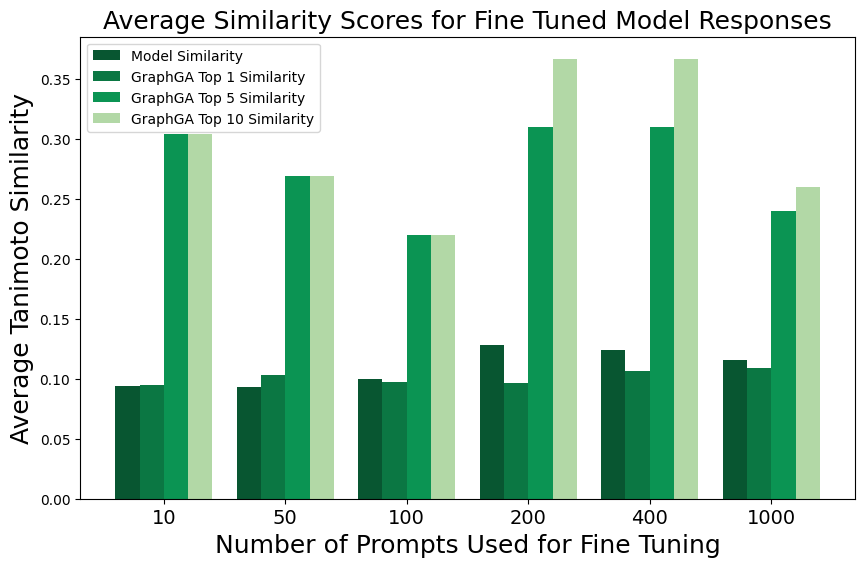

In [17]:
import matplotlib.pyplot as plt
import pandas as pd


# Example DataFrame with experiment results
data = {
    'Experiment': titles,
    'Model_similarity': Model_similarity,
    'GraphGA_1st_similarity': GraphGA_1st_similarity,
    'GraphGA_5th_similarity': GraphGA_5st_similarity,
    'GraphGA_10th_similarity': GraphGA_10st_similarity
}

df = pd.DataFrame(data)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.2

# Position of each group of bars
bar_positions = range(len(df['Experiment']))

# Plot bars for each result
ax.bar([pos - 1.5 * bar_width for pos in bar_positions], df['Model_similarity'], width=bar_width, label='Model Similarity',color=colors[0])
ax.bar([pos - 0.5 * bar_width for pos in bar_positions], df['GraphGA_1st_similarity'], width=bar_width, label='GraphGA Top 1 Similarity',color=colors[1])
ax.bar([pos + 0.5 * bar_width for pos in bar_positions], df['GraphGA_5th_similarity'], width=bar_width, label='GraphGA Top 5 Similarity',color=colors[2])
ax.bar([pos + 1.5 * bar_width for pos in bar_positions], df['GraphGA_10th_similarity'], width=bar_width, label='GraphGA Top 10 Similarity',color=colors[3])

# Set labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['Experiment'], fontsize=14)
ax.set_xlabel('Number of Prompts Used for Fine Tuning',fontsize=18)
ax.set_ylabel('Average Tanimoto Similarity',fontsize=18)
ax.set_title('Average Similarity Scores for Fine Tuned Model Responses',fontsize=18)

# Add legend
ax.legend(fontsize=10)
# Show the plot
plt.show()

In [61]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 10.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
import random
from scipy.stats import binom
import math


def create_hand(num_dice):
    """
    num_dice: int [1, 5] of number of dice to roll

    return a list of `num_dice` integers randomly generated between 1 and 6
    """
    if not 0 <= num_dice <= 5:
        raise ValueError(f"Choose number between 0-5 for dice number. You chose {num_dice}.")
    hand =[]
    for i in range(num_dice):
        hand.append(random.randint(1, 6))
    return hand


class LiarsDiceGame:
    def __init__(self, player1_hand_object, player2_hand_object):
        """
        player1_hand_object: player1's LiarsDiceHand
        player2_hand_object: player2's LiarsDiceHand
        
        Initalize a Game of Liars Dice. Player1 will query first by default
        """

        # make sure valid initialization
        self.valid(player1_hand_object, player2_hand_object)
        
        self.player1_hand_object = player1_hand_object
        self.player1_name = player1_hand_object.name
        self.player2_hand_object = player2_hand_object
        self.player2_name = player2_hand_object.name
        self.turn = self.player1_name
        self.round_number = 1
        self.game_over = False

        # dictionary of game history
        # keys: round #
        # values: dictionary of information in that round
            # keys: "Hands", "Actions", "Winner", "Loser"
            # values:
                # Names and Hands of the players: {"Name" : hand(list)}
                # Bids: ["Bid", bidding player, bid dice quantity, bid dice value, correct bid?] 
                #   / Challenges: ["Challenge", challenging player, bid dice quantity challenged, bid dice value challenged, successful challenge?]
                # Winner: "Winner Name"
                # Loser: "Loser Name"
        self.game_history = {1: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             2: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             3: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             4: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             5: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             6: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             7: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             8: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}, 
                             9: {"Hands": {}, "Actions":[], "Winner": "", "Loser": ""}}

    def valid(self, player1_hand_object, player2_hand_object):
        """
        Ensure valid game configeration
        """
        assert len(player1_hand_object) == player2_hand_object.opponent_length(), "Inconsistent hand sizes"
        assert len(player2_hand_object) == player1_hand_object.opponent_length(), "Inconsistent hand sizes"

    def bid(self, bidding_player, bid_dice_quantity, bid_dice_value):
        """
        bidding_player: name of player whose turn it is
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on
        is_bid_challenged: boolean

        Adds bid to self.bid_history
        """
        # check that the correct player is bidding this turn
        assert bidding_player == self.turn

        is_bid_correct = self.correct_bid_total(bid_dice_quantity, bid_dice_value)
        self.game_history[self.round_number]["Actions"].append(["Bid", bidding_player, bid_dice_quantity, bid_dice_value, is_bid_correct])

        # switch turns
        if bidding_player == self.player1_name:
            self.turn = self.player2_name
        else:
            self.turn = self.player1_name

        print(f'{bidding_player} bid {bid_dice_quantity} dice of value {bid_dice_value}. Correct? {is_bid_correct}.')

    def correct_bid_total(self, bid_dice_quantity, bid_dice_value):
        """
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on

        Return boolean if there exists >= `bid_dice_quantity` of `bid_dice_value` 
        """
        # correct bid considering both players' hands
        quantity = self.player1_hand_object.user_hand.count(bid_dice_value) + self.player2_hand_object.user_hand.count(bid_dice_value)
        correct = (quantity >= bid_dice_quantity)

        return correct

    def correct_bid_self(self, player_name, bid_dice_quantity, bid_dice_value):
        """
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on

        Return boolean if there exists >= `bid_dice_quantity` of `bid_dice_value` 

        """
        # correct bid looking **only at player_name's** hand
        if player_name == self.player1_name:
            player_hand = self.player1_hand_object
        else:
            player_hand = self.player2_hand_object
        quantity = player_hand.user_hand.count(bid_dice_value) 
        
        correct = (quantity >= bid_dice_quantity)
        return correct

    def challenge_bid(self, bid_dice_quantity, bid_dice_value, challenging_player_name):
        """
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on
        challenging_player_name: str of player's name that is making the challenge

        Update game state after a bid challenge. Print the number of dice remaining after losing player has lost a dice and
        both players have rerolled. Also print the winner and loser of this challenge as this determines the player that 
        makes the next bid
        """
        is_correct_bid = self.correct_bid_total(bid_dice_quantity, bid_dice_value)
        is_successful_challenge = not is_correct_bid

        # update game history with current hands and challenge
        self.game_history[self.round_number]["Hands"][self.player1_name] = self.player1_hand_object.user_hand
        self.game_history[self.round_number]["Hands"][self.player2_name] = self.player2_hand_object.user_hand
        self.game_history[self.round_number]["Actions"].append(["Challenge", challenging_player_name, bid_dice_quantity, bid_dice_value, is_successful_challenge])

        # rerolls and loser gets next turn
        if challenging_player_name == self.player1_name:
            if is_correct_bid: # player 1 lost challenge, loses 1 die
                self.player1_hand_object.decrement_and_reroll(True)
                self.player2_hand_object.decrement_and_reroll(False)
                winner, loser = self.player2_name, self.player1_name
                self.turn = self.player1_name
            else: # player 2 lost challenge, loses 1 die
                self.player1_hand_object.decrement_and_reroll(False)
                self.player2_hand_object.decrement_and_reroll(True)
                winner, loser = self.player1_name, self.player2_name
                self.turn = self.player2_name
        elif challenging_player_name == self.player2_name:
            if is_correct_bid: # player 2 lost challenge, loses 1 die
                self.player1_hand_object.decrement_and_reroll(False)
                self.player2_hand_object.decrement_and_reroll(True)
                winner, loser = self.player1_name, self.player2_name
                self.turn = self.player2_name
            else: # player 1 lost challenge, loses 1 die
                self.player1_hand_object.decrement_and_reroll(True)
                self.player2_hand_object.decrement_and_reroll(False)
                winner, loser = self.player2_name, self.player1_name
                self.turn = self.player1_name
        else:
            raise NameError(f'{challenging_player_name} not valid name. Must be {self.player1_name} or {self.player2_name}')
        
        # current round ends, update game history with results
        self.game_history[self.round_number]["Winner"] = winner
        self.game_history[self.round_number]["Loser"] = loser
        
        self.round_number += 1

        remaining_dice_player1 = self.player1_hand_object.user_num_dice
        remaining_dice_player2 = self.player2_hand_object.user_num_dice
        
        # print info per the spec
        print(f'{challenging_player_name} challenged. Challenge successful? {is_successful_challenge}')
        print(f'Winner of challenge: {winner}. Loser of challenge: {loser}.')
        print(f'{self.player1_name} has {remaining_dice_player1} dice remaining.')
        print(f'{self.player2_name} has {remaining_dice_player2} dice remaining.')

        if remaining_dice_player1 > 0 and remaining_dice_player2 > 0:
            print(f'{self.turn} has the next turn.\n')
        else:
            print(f"Game over. {winner} wins, {loser} loses.\n")
            self.game_over = True
    
    def access_hand(self, player_name):
        """
        player_name: str of name (must be equal to self.player1_name or self.player2_name)

        Return `player_name`s hand object
        """

        if player_name == self.player1_name:
            return self.player1_hand_object
        elif player_name == self.player2_name:
            return self.player2_hand_object
        else:
            raise NameError(f'{player_name} not valid name. Must be {self.player1_name} or {self.player2_name}')
        
    def get_game_history(self):
        """
        Prints readable/formatted game history
        """
        print("GAME HISTORY: \n")
        for round, info in self.game_history.items():
            print(f'Round {round}:')
            for key, value in info.items():
                print(f'\t{key}: {value}')
        

class LiarsDiceHand:
    def __init__(self, name, user_hand, opponent_num_dice):
        """
        user_hand: list integers randomly generated between 1 and 6. 1 <= len(user_hand) <= 5
        opponent: integer of opponent's hand size [1, 5] 
        
        Initalize a user's hand
        """
        self.valid(user_hand, opponent_num_dice)

        self.name = name
        self.user_hand = user_hand
        self.user_num_dice = len(user_hand)

        self.dice_dict = self.convert_list_to_dict(user_hand) # instantiate

        self.opponent_num_dice = opponent_num_dice
        uniform_prob = opponent_num_dice / 6
        self.expected_opponent_hand = {1: uniform_prob, 2: uniform_prob, 3: uniform_prob, 4: uniform_prob, 5: uniform_prob, 6: uniform_prob} 
    
    def convert_list_to_dict(self, hand):
        res = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0} # instantiate
        for die in hand:
            res[die] += 1
        return res

    def valid(self, user_hand, opponent_num_dice):
        """
        user_hand: list integers randomly generated between 1 and 6. 1 <= len(user_hand) <= 5
        opponent: integer of opponent's hand size [1, 5] 
        
        Ensure valid hand configuration
        """
        user_num_dice = len(user_hand)

        assert ((user_num_dice > 0) or (opponent_num_dice > 0)), "At least one player must have positive dice"

        assert (user_num_dice >= 0), "User can't have negative dice"
        assert (opponent_num_dice >= 0), "Opponent can't have negative dice"
    
    def decrement_and_reroll(self, user_loser):
        """
        user_loser: boolean True if user lost round, boolean False if opponent lost round
        
        Decrement one from the num_dice value of the loser, and reroll user's hand using the `create_hand` helper function
        
        Throw error if decrementing self.user_num_dice or self.opponent_num_dice results in a value
        of either of them below 0 OR both of them below 1  
        """
        new_user_num_dice = self.user_num_dice
        new_opponent_num_dice = self.opponent_num_dice

        if user_loser:
            assert new_user_num_dice > 0, "User can't have negative dice"
            new_user_num_dice -= 1
        else:
            assert new_opponent_num_dice > 0, "Opponent can't have negative dice"
            new_opponent_num_dice -= 1
        
        new_user_hand = create_hand(new_user_num_dice)

        self.valid(new_user_hand, new_opponent_num_dice)

        self.user_hand = new_user_hand
        self.user_num_dice = new_user_num_dice
        self.opponent_num_dice = new_opponent_num_dice
        self.update_dice_dict()

    def update_dice_dict(self):
        """
        """
        self.dice_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0} # instantiate
        for die in self.user_hand:
            self.dice_dict[die] += 1

    def compute_expected_values(self):
        """
        Return a dictionary of the expected number of each dice from the user's perspective
        
        """
        total_dict = {}

        # the expected number of each dice in the opponent's hand is (1/6 * # of dice opponent has)
        for i in self.dice_dict.keys():
            total_dict[i] = self.dice_dict[i] + 1/6 * self.opponent_length()
        
        return total_dict

    def compute_blind_probability(self, bid_dice_quantity, bid_dice_value):
        """
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on

        Return the probability of bid being correct from the perspective of the user (since they only have information about their hand and the size of the opponents hand) 
        This is the "blind" probability because it does not factor in any knowledge learned from previous games
        """
        quantity_opponent_needs_to_have = int(bid_dice_quantity - self.dice_dict[bid_dice_value])
        if quantity_opponent_needs_to_have <= 0:
            return 1

        # Probability of rolling at least k of a value = 
        # sum from k to 5 of [(5 choose k) * (1/6)^k * (5/6)^(5-k)]
        # basically the sum from k to 5 of binom.pmf(k=k,n=5,p=1/6)

        probability_sum = 0
        for k in range(quantity_opponent_needs_to_have, self.opponent_num_dice + 1):
            probability_sum += binom.pmf(k=k, n=self.opponent_num_dice, p=1/6)

        return probability_sum

    def update_opponent_expected_hand(self, opponent_bids):
        """
        opponent_bids: list of opponent's bids in the format [quantity, value]

        Update the expected hand of the opponent based on their bids
        """
        TODO #Could be good to implement

    def compute_conditional_probability(self, bid_dice_quantity, bid_dice_value, opponent_prob_bluff):
        """
        bid_dice_quantity: int of the quantity of dice bid on
        bid_dice_value: int of the value of dice bid on
        opponent_prob_bluff: the probability that your opponent will bluff on any given die


        Return the probability of bid being correct from the perspective of the user.
        This is the "conditional" probability because it conditions on knowledge learned (what dice you believe the other player has) 
        from previous games as well as the bluffing probability
        """
        quantity_opponent_needs_to_have = int(bid_dice_quantity - self.dice_dict[bid_dice_value])
        if quantity_opponent_needs_to_have <= 0:
            return 1
        
        expected_opponent_quantity_of_bid_value = round(self.expected_opponent_hand[bid_dice_value], 0)
        opponent_potential_bluff_dice = int(self.opponent_length() - expected_opponent_quantity_of_bid_value)
        expected_opponent_bluff = quantity_opponent_needs_to_have - expected_opponent_quantity_of_bid_value

        # P(opponent bluffed about `expected_opponent_bluff`` dice given they bluff with opponent_prob_bluff probability)
        # Prior Probability (P(A))
        prior_probability = binom.pmf(expected_opponent_bluff, opponent_potential_bluff_dice, opponent_prob_bluff)

        # Likelihood (P(B|A)) - Assuming that the likelihood of observing opponent_potential_bluff_dice given a bluff is 1
        likelihood = 1

        # Marginal Likelihood (P(B))
        marginal_likelihood = sum([binom.pmf(i, opponent_potential_bluff_dice, opponent_prob_bluff) for i in range(opponent_potential_bluff_dice + 1)])

        # Posterior Probability (P(A|B))
        posterior_probability = (likelihood * prior_probability) / marginal_likelihood
        
        return posterior_probability


    def __str__(self):
        """
        Return a string representation of the current game state from the user's perspective
        """
        user_hand_str = ', '.join(map(str, self.user_hand))

        return (f"{self.name}\n"
                f"Hand: [{user_hand_str}]\n"
                f"Number of dice: {self.user_num_dice}\n"
                f"Opponent's number of dice: {self.opponent_num_dice}\n")
    
    def __len__(self):
        """
        Return size of user's hand
        """
        return self.user_num_dice
    
    def opponent_length(self):
        """
        Return size of opponent's hand
        """
        return self.opponent_num_dice


if __name__ == "__main__":
    # Set Up
    starting_num_dice = 5
    joey_hand_values = create_hand(starting_num_dice)
    dana_hand_values = create_hand(starting_num_dice)

    joey_hand = LiarsDiceHand("Joey", joey_hand_values, len(dana_hand_values))
    dana_hand = LiarsDiceHand("Dana", dana_hand_values, len(joey_hand_values))

    game1 = LiarsDiceGame(joey_hand, dana_hand)

    # Game Simulation
    round_number = 1   

    while not game1.game_over:
        print(f'Round #{round_number}')
        print(game1.access_hand("Joey"))
        print(game1.access_hand("Dana"))
        player_turn = game1.turn

        # Opening Bid: Randomly choose a quantity x value that they actually have (never bluff)
        value = np.random.choice(game1.access_hand(player_turn).user_hand)
        quantity = np.random.randint(1, game1.access_hand(player_turn).dice_dict[value] + 1)

        game1.bid(player_turn, quantity, value)

        round_over = False

        while not round_over:
            player_turn = game1.turn
            if player_turn == game1.player1_name: 
                player_hand = game1.player1_hand_object
                opponent_hand = game1.player2_hand_object
            else: 
                player_hand = game1.player2_hand_object
                opponent_hand = game1.player1_hand_object

            ## Uncomment next 3 lines if we want to change agent's behavior to probability-independent.
            ## if player has other player's bid in their own hand, they will bid. else, they will challenge. 
            ## (player always assumes that the other player actually has 0 of the bidded value -- assumes other player is always bluffing)
            # if game1.correct_bid_self(player_turn, quantity, value):

            # Probability dependent agent (comment out next line if we switch to probability-independent behavior)
            if player_hand.compute_blind_probability(quantity, value) > 0.4: # bid likely enough to consider not challenging
                num_dice_left = len(player_hand) + len(opponent_hand)
                if value == 6 and quantity == num_dice_left: # the player is forced to challenge, because there are no more possible bids
                    game1.challenge_bid(quantity, value, player_turn)
                    round_over = True
                else: # player chooses a random possible bid (must be either higher in value or higher in quantity or both)
                    new_value, new_quantity = value, quantity
                    while new_value == value and new_quantity == quantity:
                        new_value = np.random.randint(value, 7)
                        new_quantity = np.random.randint(quantity, num_dice_left +1)
                    value, quantity = new_value, new_quantity
                    game1.bid(player_turn, quantity, value)
            else:
                game1.challenge_bid(quantity, value, player_turn)
                round_over = True

        round_over = False
        round_number += 1

    game1.get_game_history()





Round #1
Joey
Hand: [5, 3, 6, 5, 1]
Number of dice: 5
Opponent's number of dice: 5

Dana
Hand: [1, 4, 6, 1, 5]
Number of dice: 5
Opponent's number of dice: 5

Joey bid 1 dice of value 1. Correct? True.
Dana bid 9 dice of value 1. Correct? False.
Joey challenged. Challenge successful? True
Winner of challenge: Joey. Loser of challenge: Dana.
Joey has 5 dice remaining.
Dana has 4 dice remaining.
Dana has the next turn.

Round #2
Joey
Hand: [1, 4, 4, 3, 1]
Number of dice: 5
Opponent's number of dice: 4

Dana
Hand: [1, 1, 6, 6]
Number of dice: 4
Opponent's number of dice: 5

Dana bid 1 dice of value 1. Correct? True.
Joey bid 7 dice of value 1. Correct? False.
Dana challenged. Challenge successful? True
Winner of challenge: Dana. Loser of challenge: Joey.
Joey has 4 dice remaining.
Dana has 4 dice remaining.
Joey has the next turn.

Round #3
Joey
Hand: [2, 4, 4, 4]
Number of dice: 4
Opponent's number of dice: 4

Dana
Hand: [2, 6, 1, 6]
Number of dice: 4
Opponent's number of dice: 4

Joey b

In [59]:
g = {1.0: 
     {'Round 1.0': 
      {'Hands': {'Me': [1, 2, 3, 5, 5], 'Subject': [3, 5, 6, 6, 6]}, 
       'Actions': [['Bid', 'Me', 1.0, 5.0, True], ['Bid', 'Subject', 3.0, 6.0, True], ['Challenge', 'Me', 3.0, 6.0, False]], 
       'Winner': 'Subject', 'Loser': 'Me'},
      'Round 2.0': {'Hands': {'Me': [1, 2, 3, 5], 'Subject': [2, 3, 4, 5, 6]}, 'Actions': [['Bid', 'Me', 2.0, 2.0, True], ['Bid', 'Subject', 3.0, 2.0, False], ['Bid', 'Me', 1.0, 3.0, True], ['Bid', 'Subject', 2.0, 4.0, False], ['Challenge', 'Me', 2.0, 4.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 3.0': {'Hands': {'Me': [1, 2, 3, 6], 'Subject': [2, 2, 3, 6]}, 'Actions': [['Bid', 'Subject', 2.0, 2.0, True], ['Bid', 'Me', 3.0, 2.0, True], ['Bid', 'Subject', 1.0, 6.0, True], ['Bid', 'Me', 2.0, 6.0, True], ['Challenge', 'Subject', 2.0, 6.0, False]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 4.0': {'Hands': {'Me': [2, 6, 6, 6], 'Subject': [2, 3, 6]}, 'Actions': [['Bid', 'Subject', 2.0, 3.0, False], ['Bid', 'Me', 3.0, 6.0, True], ['Challenge', 'Subject', 3.0, 6.0, False]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 5.0': {'Hands': {'Me': [2, 2, 2, 3], 'Subject': [4, 4]}, 'Actions': [['Bid', 'Subject', 2.0, 4.0, True], ['Challenge', 'Me', 2.0, 4.0, False]], 'Winner': 'Subject', 'Loser': 'Me'}, 'Round 6.0': {'Hands': {'Me': [2, 2, 3], 'Subject': [1, 5]}, 'Actions': [['Bid', 'Me', 1.0, 2.0, True], ['Bid', 'Subject', 2.0, 5.0, False], ['Challenge', 'Me', 2.0, 5.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 7.0': {'Hands': {'Me': [2, 3, 6], 'Subject': [3]}, 'Actions': [['Bid', 'Subject', 2.0, 4.0, False], ['Challenge', 'Me', 2.0, 4.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}}, 2.0: {'Round 1.0': {'Hands': {'Me': [1, 2, 3, 5, 5], 'Subject': [3, 5, 6, 6, 6]}, 'Actions': [['Bid', 'Me', 1.0, 5.0, True], ['Bid', 'Subject', 3.0, 6.0, True], ['Challenge', 'Me', 3.0, 6.0, False]], 'Winner': 'Subject', 'Loser': 'Me'}, 'Round 2.0': {'Hands': {'Me': [1, 2, 3, 5], 'Subject': [2, 3, 4, 5, 6]}, 'Actions': [['Bid', 'Me', 2.0, 2.0, True], ['Bid', 'Subject', 3.0, 2.0, False], ['Bid', 'Me', 1.0, 3.0, True], ['Bid', 'Subject', 2.0, 4.0, False], ['Challenge', 'Me', 2.0, 4.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 3.0': {'Hands': {'Me': [1, 2, 3, 6], 'Subject': [2, 2, 3, 6]}, 'Actions': [['Bid', 'Subject', 2.0, 2.0, True], ['Bid', 'Me', 3.0, 2.0, True], ['Bid', 'Subject', 1.0, 6.0, True], ['Bid', 'Me', 2.0, 6.0, True], ['Challenge', 'Subject', 2.0, 6.0, False]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 4.0': {'Hands': {'Me': [2, 6, 6, 6], 'Subject': [2, 3, 6]}, 'Actions': [['Bid', 'Subject', 2.0, 3.0, False], ['Bid', 'Me', 3.0, 6.0, True], ['Challenge', 'Subject', 3.0, 6.0, False]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 5.0': {'Hands': {'Me': [2, 2, 2, 3], 'Subject': [4, 4]}, 'Actions': [['Bid', 'Subject', 2.0, 4.0, True], ['Challenge', 'Me', 2.0, 4.0, False]], 'Winner': 'Subject', 'Loser': 'Me'}, 'Round 6.0': {'Hands': {'Me': [2, 2, 3], 'Subject': [1, 5]}, 'Actions': [['Bid', 'Me', 1.0, 2.0, True], ['Bid', 'Subject', 2.0, 5.0, False], ['Challenge', 'Me', 2.0, 5.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}, 'Round 7.0': {'Hands': {'Me': [2, 3, 6], 'Subject': [3]}, 'Actions': [['Bid', 'Subject', 2.0, 4.0, False], ['Challenge', 'Me', 2.0, 4.0, True]], 'Winner': 'Me', 'Loser': 'Subject'}}}

In [63]:
for i in g:
    print(i)

1.0
2.0


In [64]:
def history_to_obj(history):
    """
    takes a history
    returns a list of games
    objects.
    """
    games = []
    for g in history:
        for round in history[g]:
            hand1 = LiarsDiceHand("Me", history[g][round]["Hands"]["Me"], len(history[g][round]["Hands"]["Me"]))
            hand2 = LiarsDiceHand("Subject", history[g][round]["Hands"]["Subject"], len(history[g][round]["Hands"]["Subject"]))

            game1 = LiarsDiceGame(hand1, hand2)

            for action in history[g][round]["Actions"]:
                player_turn = action[1]
                quantity = action[2]
                value = action[3]
                print(player_turn,quantity,value)
                if action[0] == "Callenge":
                    game1.challenge_bid(quantity, value, player_turn)
                else:
                    game1.bid(player_turn, quantity, value)
            games.append(game)
    return games


    

In [65]:
history_to_obj(g)

Me 1.0 5.0
Me bid 1.0 dice of value 5.0. Correct? True.
Subject 3.0 6.0
Subject bid 3.0 dice of value 6.0. Correct? True.
Me 3.0 6.0
Me bid 3.0 dice of value 6.0. Correct? True.


AssertionError: Inconsistent hand sizes